## Negative Binomial VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Negative Binomial base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under our Quasi-Copula model with $\beta \sim$ randn(p) where p = 3 fixed effects.

We use multi-threading on 8 threads to obtain these MSE results on the following machine, and include MSE results from 100 simulation runs comparing the fit of ours with that of the random intercept Negative Binomial GLMM from MixedModels.jl for each scenario.

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using QuasiCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using DataFrames

In [3]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(12345)
βtrue = rand(Uniform(-0.2, 0.2), p)
rtrue = 10.0
θtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; rtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100;

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_theta_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
 0.050143609
 0.193592773
 0.135597127
 0.045668911
 0.232487525
 0.244640913
 0.252177759
 0.173747143
 0.046075343
 0.296215098
 0.20163482
 0.22022374
 0.170185888
 ⋮
 6.189337658
 6.247400937
 6.00278709
 6.079518391
 6.030051843
 6.104174174
 6.056407183
 6.152436985
 6.113998348
 6.016825301
 6.014865309
 6.161880892

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
  0.291323389
  0.042420557
  0.035935438
  0.015137405
  0.052944313
  0.043638413
  0.016796412
  0.041503579
  0.012624645
  0.041584924
  0.036381149
  0.015221032
  0.046662489
  ⋮
 39.57685549
 50.342858691
 39.424701046
 45.077493687
 54.367856998
 48.311559682
 45.965053312
 45.653669558
 41.072851848
 53.042116292
 58.467129019
 37.935693579

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.184785,0.0108726,200,0.173913,0.195658,0.000923927
2,100,5,0.185839,0.00456401,500,0.181275,0.190403,0.000371678
3,100,10,0.195642,0.00565287,1000,0.189989,0.201295,0.000195642
4,100,15,0.212008,0.00562695,1500,0.206381,0.217635,0.000141339
5,100,20,0.207338,0.00686901,2000,0.200469,0.214207,0.000103669
6,100,25,0.226467,0.010744,2500,0.215723,0.237211,9.05868e-5
7,1000,2,0.325536,0.00622898,2000,0.319307,0.331765,0.000162768
8,1000,5,0.366634,0.00511817,5000,0.361516,0.371752,7.33268e-5
9,1000,10,0.394006,0.00264568,10000,0.39136,0.396651,3.94006e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,0.02961,0.0032549,200,0.0263551,0.0328649,0.00014805
2,100,5,0.0451908,0.00125213,500,0.0439387,0.046443,9.03816e-5
3,100,10,0.0990221,0.00502559,1000,0.0939965,0.104048,9.90221e-5
4,100,15,0.169429,0.00871183,1500,0.160718,0.178141,0.000112953
5,100,20,0.255359,0.0107466,2000,0.244613,0.266106,0.00012768
6,100,25,0.356626,0.0135027,2500,0.343124,0.370129,0.000142651
7,1000,2,0.196118,0.00306513,2000,0.193053,0.199183,9.80591e-5
8,1000,5,0.403979,0.00593872,5000,0.398041,0.409918,8.07959e-5
9,1000,10,0.889545,0.0158213,10000,0.873723,0.905366,8.89545e-5


In [8]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_r_theta_coverage_multivariate_NB_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["r"]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p];  ["r"];  ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,r
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.66, 0.0476095)","(0.79, 0.040936)","(0.74, 0.0440844)","(0.71, 0.0456048)"
2,N: 100 ni: 5,"(0.61, 0.0490207)","(0.78, 0.0416333)","(0.78, 0.0416333)","(0.8, 0.0402015)"
3,N: 100 ni: 10,"(0.56, 0.0498888)","(0.7, 0.0460566)","(0.72, 0.0451261)","(0.7, 0.0460566)"
4,N: 100 ni: 15,"(0.68, 0.0468826)","(0.69, 0.0464823)","(0.77, 0.0422953)","(0.82, 0.0386123)"
5,N: 100 ni: 20,"(0.64, 0.0482418)","(0.76, 0.0429235)","(0.73, 0.0446196)","(0.84, 0.0368453)"
6,N: 100 ni: 25,"(0.71, 0.0456048)","(0.73, 0.0446196)","(0.67, 0.0472582)","(0.91, 0.0287623)"
7,N: 1000 ni: 2,"(0.7, 0.0460566)","(0.83, 0.0377525)","(0.83, 0.0377525)","(0.86, 0.0348735)"
8,N: 1000 ni: 5,"(0.37, 0.0485237)","(0.44, 0.0498888)","(0.88, 0.0326599)","(0.78, 0.0416333)"
9,N: 1000 ni: 10,"(0.45, 0.05)","(0.55, 0.05)","(0.81, 0.0394277)","(0.8, 0.0402015)"


In [9]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_theta_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult =  vec(readdlm("mse_r_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_theta_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult_GLMM =  vec(readdlm("mse_r_GLMMmultivariate_NB_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, rmse = rMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, rmse = rMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse];msedf1[!, :rmse]; msedf2[!, :betamse]; msedf2[!, :thetamse]; msedf2[!, :rmse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Negative Binomial QC"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Negative Binomial GLMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.00349731,2,100,beta,Negative Binomial QC
2,0.00319388,2,100,beta,Negative Binomial QC
3,0.00395464,2,100,beta,Negative Binomial QC
4,0.00174776,2,100,beta,Negative Binomial QC
5,0.00661194,2,100,beta,Negative Binomial QC
6,0.00887658,2,100,beta,Negative Binomial QC
7,0.0181029,2,100,beta,Negative Binomial QC
8,0.00418921,2,100,beta,Negative Binomial QC
9,0.00290134,2,100,beta,Negative Binomial QC


┌ Warning: RCall.jl: Warning: package ‘scales’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172
┌ Warning: RCall.jl: Warning: package ‘data.table’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/6kphM/src/io.jl:172


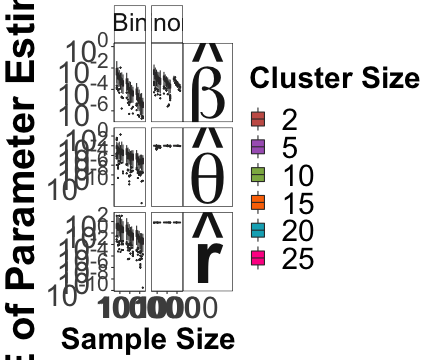

RObject{VecSxp}


In [10]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-4]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "r", y_min := 10^-3]
msedfR[parameters == "r", y_max := 10^3]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'r'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), r = expression(hat(bold(r))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Negative Binomial QC', 'Negative Binomial GLMM'),
    labels = c(expression(paste("Negative Binomial QC")), expression(paste("Negative Binomial GLMM"))))

#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [11]:
R"""
    ggsave('updated_msefacetplot_nb_sim1.png', mseplot, width = 20, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_nb_sim1.png"
